# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 376 kB 60.5 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=3c245ea2ef8b577272964cf25444d0942f8f1549aff361a1cd79e337226bc4b6
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8b25e89bbc989b81b8849ae3fb728ab5eafebe0311842434e237bc7ec7548952
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

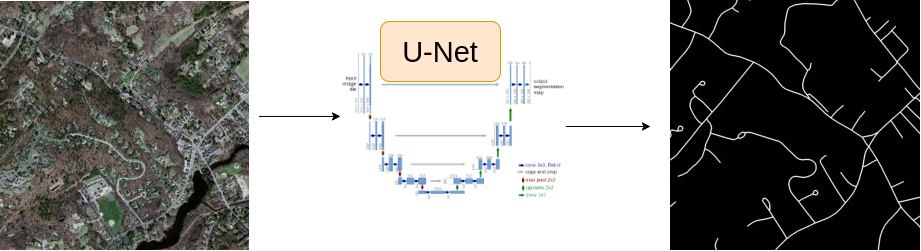

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Road_seg_dataset/train.csv'
DATA_DIR='/content/Road_seg_dataset/'

DEVICE='cuda'

EPOCHS = 25
LR=0.003
BATCH_SIZE = 8
IMG_SIZE = 512
ENCODE= 'timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx =2
row =df.iloc[idx]

image_path = DATA_DIR +row.images
mask_path = DATA_DIR +row.masks

image =cv2.imread(image_path)

image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

print(image) or print(image.shape)

[[[ 14  17  10]
  [ 14  17  11]
  [ 13  15  10]
  ...
  [ 82  91 101]
  [ 84  90  97]
  [ 80  92 104]]

 [[ 14  14   7]
  [ 14  17  13]
  [ 14  15   9]
  ...
  [ 83  96 103]
  [ 94 100 106]
  [ 86  97 105]]

 [[ 14  15  11]
  [ 16  16  10]
  [ 14  15  11]
  ...
  [ 79  90 101]
  [ 89  96 103]
  [ 84  96 106]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 55  75  52]
  [ 41  57  32]
  [ 65  71  46]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 41  56  29]
  [118 118 102]
  [ 36  29  21]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [124 128 101]
  [ 12  18   7]
  [ 12  16  16]]]
(1500, 1500, 3)


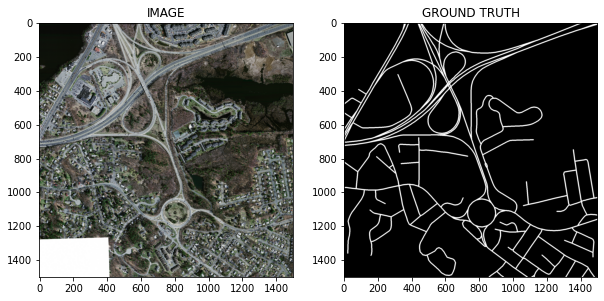

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):

    row =self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image =cv2.imread(image_path)

    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#(h,w,s)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expend_dims(mask , axis=-1)#(h,w,c)
    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image = data['image']#(h,w,s)
      mask = data['mask']
    image= np.transpose(image,(2,0,1)).astype(np.float32)#(c,h,w)
    mask= np.transpose(mask,(2,0,1)).astype(np.float32)#(c,h,w)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [ ]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


In [ ]:
idx =69
image , mask = trainset[idx]

helper.show_image(image, mask)

AttributeError: ignored

# Task 5 : Load dataset into batches

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Task 7 : Create Train and Validation Function

# Task 8 : Train Model

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

